In [1]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import pandas as pd

# import scienceplots
import seaborn as sns
from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")
# %config InlineBackend.figure_format='retina'

register_matplotlib_converters()
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.set_theme()


rcParams["figure.figsize"] = 12, 5
# tqdm.pandas()

In [3]:
os.getcwd()

'c:\\Users\\saoedoss\\Documents\\Repos\\Mestrado\\5g-forecasting\\notebooks'

## Carregando os dados pré processados

In [4]:
data_path = os.path.join(os.pardir, "data")
df_static = pd.read_parquet(os.path.join(data_path, "5G_df_static.parquet"))
df_driving = pd.read_parquet(os.path.join(data_path, "5G_df_driving.parquet"))

In [19]:
df_static

,Speed,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,Uid,User_Activity
Timestamp,,,,,,,,,,,,
2019-11-23 14:30:10,0.0,5G,-97.0,-12.0,10.0,13.0,NaN,0.141,0.044,D,ZARfDXXy,Streaming Video
2019-11-23 14:30:11,0.0,5G,-94.0,-13.0,8.0,11.0,NaN,0.000,0.007,D,ZARfDXXy,Streaming Video
2019-11-23 14:30:12,0.0,5G,-94.0,-13.0,8.0,11.0,NaN,0.053,0.008,D,ZARfDXXy,Streaming Video
2019-11-23 14:30:13,0.0,5G,-96.0,-13.0,4.0,11.0,NaN,0.000,0.000,I,ZARfDXXy,Streaming Video
2019-11-23 14:30:14,0.0,5G,-96.0,-13.0,4.0,11.0,NaN,0.056,0.026,D,ZARfDXXy,Streaming Video
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27 20:30:16,0.0,5G,-97.0,-17.0,13.0,10.0,-103.0,0.000,0.000,D,9X3vTPds,Downloading a File
2020-02-27 20:30:17,0.0,5G,-97.0,-17.0,9.0,10.0,-105.0,84.590,0.378,D,9X3vTPds,Downloading a File
2020-02-27 20:30:18,0.0,5G,-97.0,-17.0,9.0,10.0,-105.0,276.708,0.357,D,9X3vTPds,Downloading a File


## Separando os conjuntos em: Streaming vs. Downloading.

In [5]:
list_static_strm = df_static.query("User_Activity == 'Streaming Video'")
list_driving_strm = df_driving.query("User_Activity == 'Streaming Video'")
list_static_down = df_static.query("User_Activity == 'Downloading a File'")
list_driving_down = df_driving.query("User_Activity == 'Downloading a File'")

In [6]:
list_static_strm.columns

Index(['Speed', 'NetworkMode', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
       'DL_bitrate', 'UL_bitrate', 'State', 'Uid', 'User_Activity'],
      dtype='object')

In [7]:
print(list_driving_down)

                     Speed NetworkMode   RSRP  RSRQ  SNR   CQI  RSSI  \
Timestamp                                                              
2019-12-14 10:16:30    0.0          5G  -99.0 -15.0  6.0  12.0 -90.0   
2019-12-14 10:16:31    1.0          5G  -99.0 -15.0  6.0  12.0 -90.0   
2019-12-14 10:16:32    1.0          5G -102.0 -14.0  6.0  12.0 -90.0   
2019-12-14 10:16:33    1.0          5G -102.0 -14.0  6.0  12.0 -90.0   
2019-12-14 10:16:34    1.0          5G -102.0 -14.0  4.0  12.0 -90.0   
...                    ...         ...    ...   ...  ...   ...   ...   
2020-02-27 20:50:01   24.0       HSPA+  -71.0   NaN  NaN   NaN   NaN   
2020-02-27 20:50:02   24.0       HSPA+  -71.0   NaN  NaN   NaN   NaN   
2020-02-27 20:50:03   24.0       HSPA+  -69.0   NaN  NaN   NaN   NaN   
2020-02-27 20:50:05   24.0       HSPA+  -69.0   NaN  NaN   NaN   NaN   
2020-02-27 20:50:06   24.0       HSPA+  -75.0   NaN  NaN   NaN   NaN   

                     DL_bitrate  UL_bitrate State       Uid  \


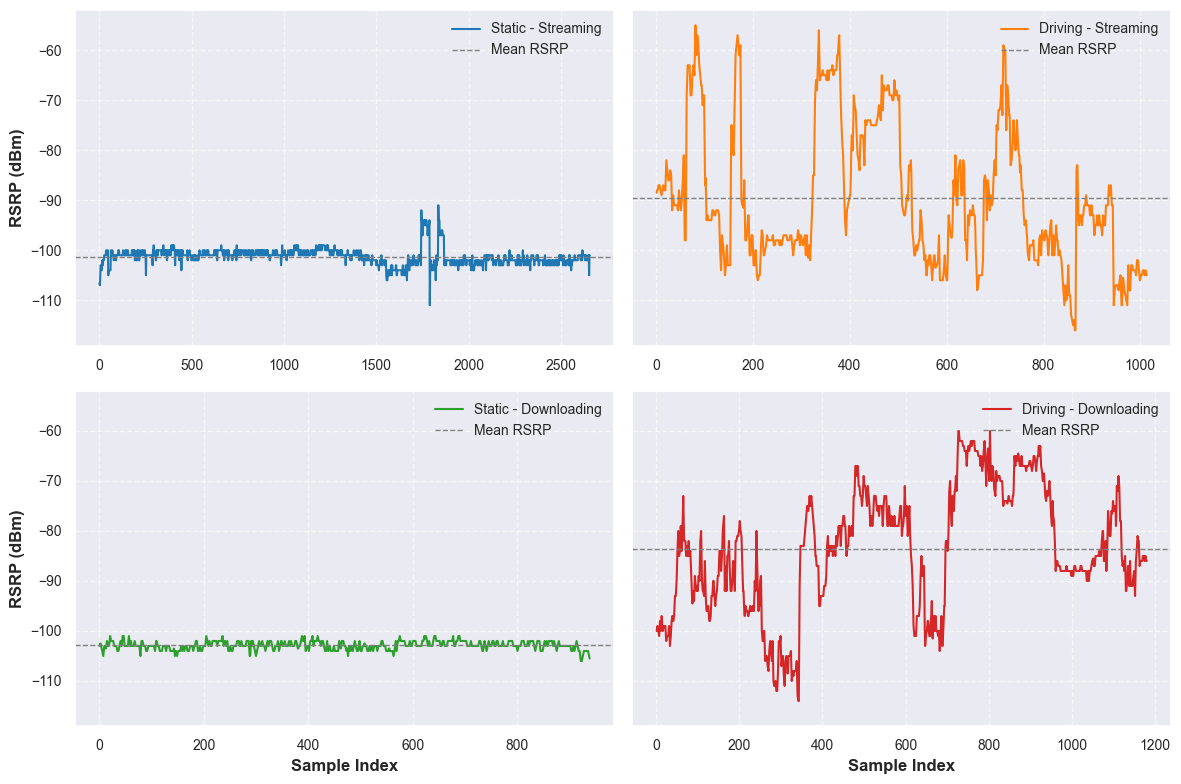

In [8]:
# Selecionar um usuário específico de cada cenário
uid_static_strm = list_static_strm.Uid.unique()[3]
uid_driving_strm = list_driving_strm.Uid.unique()[3]
uid_static_down = list_static_down.Uid.unique()[3]
uid_driving_down = list_driving_down.Uid.unique()[3]

# Criar a figura com 2 linhas e 2 colunas de subgráficos, compartilhando o eixo Y
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)

# Definição de cores e estilos de linha
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Azul, Laranja, Verde, Vermelho
linestyles = ["solid", "solid", "solid", "solid"]
window_size = 2  # Tamanho da média móvel para suavização


def plot_rsrp(ax, data, uid, color, linestyle, label):
    subset = data.query(f"Uid == '{uid}'")
    smooth_rsrp = subset["RSRP"].rolling(window=window_size, center=True).mean()
    ax.plot(
        range(len(smooth_rsrp)),
        smooth_rsrp,
        color=color,
        linestyle=linestyle,
        linewidth=1.5,
        label=label,
    )
    ax.axhline(
        y=subset["RSRP"].mean(),
        color="gray",
        linestyle="--",
        linewidth=1,
        label="Mean RSRP",
    )
    ax.legend(loc="upper right", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.6)


# Plotar RSRP com suavização e linha média
plot_rsrp(
    axes[0, 0],
    list_static_strm,
    uid_static_strm,
    colors[0],
    linestyles[0],
    "Static - Streaming",
)
plot_rsrp(
    axes[0, 1],
    list_driving_strm,
    uid_driving_strm,
    colors[1],
    linestyles[1],
    "Driving - Streaming",
)
plot_rsrp(
    axes[1, 0],
    list_static_down,
    uid_static_down,
    colors[2],
    linestyles[2],
    "Static - Downloading",
)
plot_rsrp(
    axes[1, 1],
    list_driving_down,
    uid_driving_down,
    colors[3],
    linestyles[3],
    "Driving - Downloading",
)

# Adicionar títulos e ajustes de fonte
titles = [
    ["Static - Streaming Video", "Driving - Streaming Video"],
    ["Static - Downloading File", "Driving - Downloading File"],
]

for i in range(2):
    for j in range(2):
        # axes[i, j].set_title(titles[i][j], fontsize=14, fontweight="bold")
        axes[i, 0].set_ylabel("RSRP (dBm)", fontsize=12)
        axes[i, j].tick_params(axis="both", labelsize=10)

# Ajustar rótulos do eixo X apenas na última linha
for ax in axes[1, :]:
    ax.set_xlabel("Sample Index", fontsize=12)

# Ajustar o espaçamento entre subplots
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.tight_layout()
plt.show()

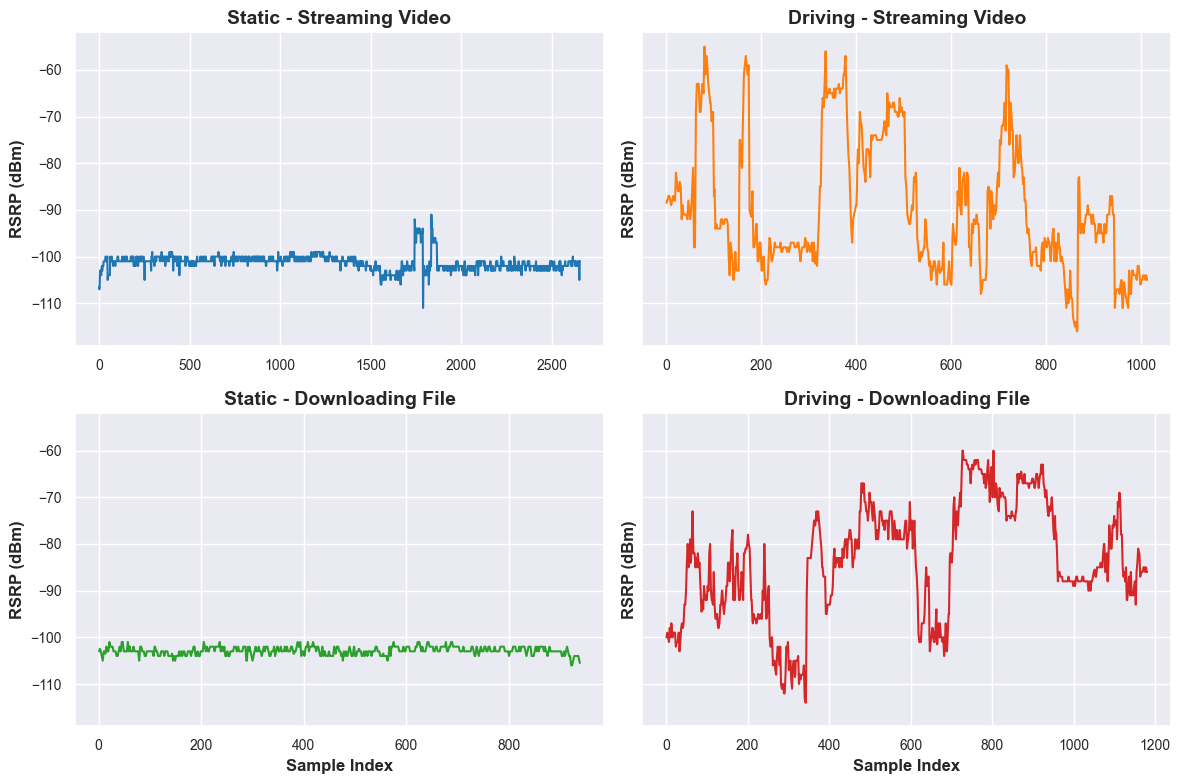

In [9]:
# Selecionar um usuário específico de cada cenário
uid_static_strm = list_static_strm.Uid.unique()[3]
uid_driving_strm = list_driving_strm.Uid.unique()[3]
uid_static_down = list_static_down.Uid.unique()[3]
uid_driving_down = list_driving_down.Uid.unique()[3]

# Criar a figura com 2 linhas e 2 colunas de subgráficos, compartilhando o eixo Y
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)

# Definição de cores e estilos de linha
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Azul, Laranja, Verde, Vermelho
# linestyles = ["dashed", "dashed", "dashdot", "dashdot"]
linestyles = ["solid", "solid", "solid", "solid"]
window_size = 2  # Tamanho da média móvel para suavização


def plot_rsrp(ax, data, uid, color, linestyle):
    subset = data.query(f"Uid == '{uid}'")
    smooth_rsrp = subset["RSRP"].rolling(window=window_size, center=True).mean()
    ax.plot(
        range(len(smooth_rsrp)),
        smooth_rsrp,
        color=color,
        linestyle=linestyle,
        linewidth=1.5,
    )
    # ax.axhline(y=subset["RSRP"].mean(), color="gray", linestyle="--", linewidth=1)


# Plotar RSRP com suavização e linha média
plot_rsrp(axes[0, 0], list_static_strm, uid_static_strm, colors[0], linestyles[0])
plot_rsrp(axes[0, 1], list_driving_strm, uid_driving_strm, colors[1], linestyles[1])
plot_rsrp(axes[1, 0], list_static_down, uid_static_down, colors[2], linestyles[2])
plot_rsrp(axes[1, 1], list_driving_down, uid_driving_down, colors[3], linestyles[3])

# Adicionar títulos e ajustes de fonte
titles = [
    ["Static - Streaming Video", "Driving - Streaming Video"],
    ["Static - Downloading File", "Driving - Downloading File"],
]

for i in range(2):
    for j in range(2):
        axes[i, j].set_title(titles[i][j], fontsize=14, fontweight="bold")
        axes[i, j].set_ylabel("RSRP (dBm)", fontsize=12)
        axes[i, j].tick_params(axis="both", labelsize=10)

# Ajustar rótulos do eixo X apenas na última linha
for ax in axes[1, :]:
    ax.set_xlabel("Sample Index", fontsize=12)

plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.tight_layout()
plt.show()


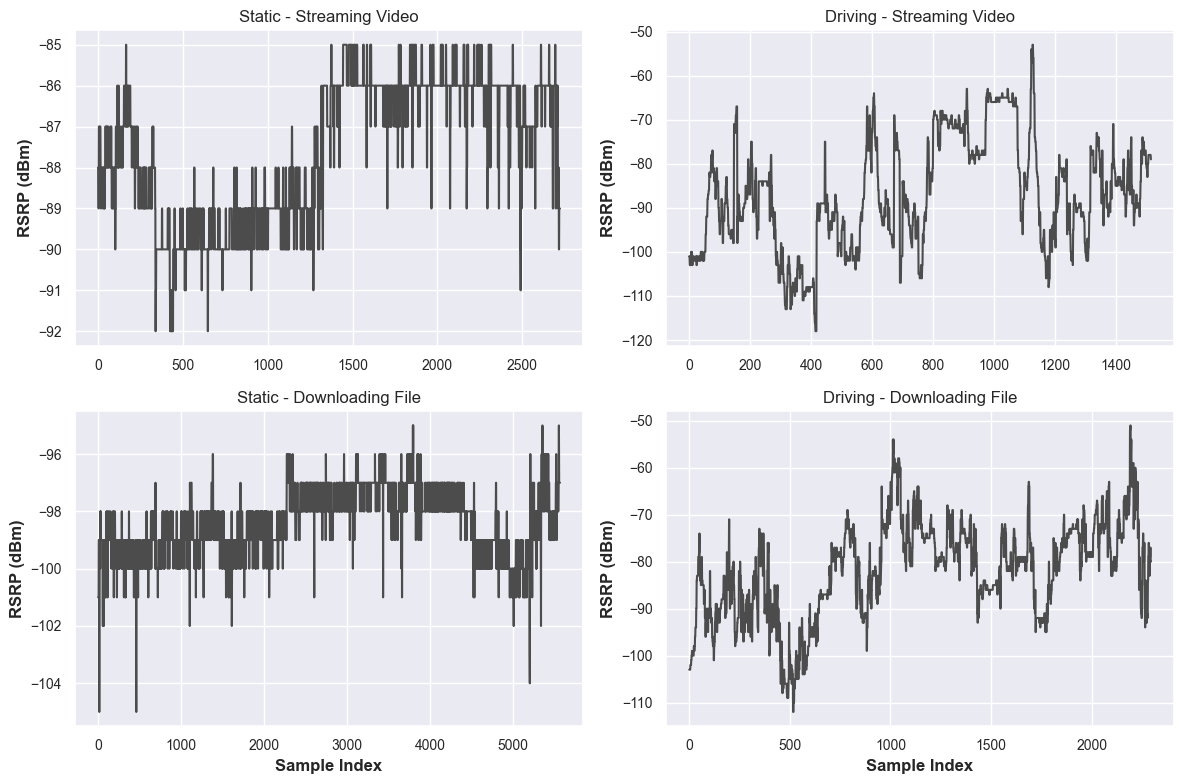

In [10]:
# Selecionar um usuário específico de cada cenário
uid_static_strm = list_static_strm.Uid.unique()[5]
uid_driving_strm = list_driving_strm.Uid.unique()[5]
uid_static_down = list_static_down.Uid.unique()[4]
uid_driving_down = list_driving_down.Uid.unique()[5]

# Criar a figura com 2 linhas e 2 colunas de subgráficos
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)

# Cor neutra para impressão em preto e branco
color = "#4C4C4C"

# Plotar RSRP para cada cenário sem considerar Timestamp
axes[0, 0].plot(
    range(len(list_static_strm.query(f"Uid == '{uid_static_strm}'"))),
    list_static_strm.query(f"Uid == '{uid_static_strm}'")["RSRP"],
    color=color,
    linewidth=1.5,
)
axes[0, 1].plot(
    range(len(list_driving_strm.query(f"Uid == '{uid_driving_strm}'"))),
    list_driving_strm.query(f"Uid == '{uid_driving_strm}'")["RSRP"],
    color=color,
    linewidth=1.5,
)
axes[1, 0].plot(
    range(len(list_static_down.query(f"Uid == '{uid_static_down}'"))),
    list_static_down.query(f"Uid == '{uid_static_down}'")["RSRP"],
    color=color,
    linewidth=1.5,
)
axes[1, 1].plot(
    range(len(list_driving_down.query(f"Uid == '{uid_driving_down}'"))),
    list_driving_down.query(f"Uid == '{uid_driving_down}'")["RSRP"],
    color=color,
    linewidth=1.5,
)

# Adicionar títulos
titles = [
    ["Static - Streaming Video", "Driving - Streaming Video"],
    ["Static - Downloading File", "Driving - Downloading File"],
]

for i in range(2):
    for j in range(2):
        axes[i, j].set_title(titles[i][j], fontsize=12)
        axes[i, j].set_ylabel("RSRP (dBm)", fontsize=12)
        axes[i, j].tick_params(axis="both", labelsize=10)

# Ajustar rótulos dos eixos apenas na última linha
for ax in axes[1, :]:
    ax.set_xlabel("Sample Index", fontsize=12)

plt.tight_layout()
plt.show()


## Experimental: Alternativa de estrategia para separar os uids e treinar os modelos

In [11]:
test_file_path = os.path.join(
    os.pardir, "data", "reduced_metrics_datasets", "driving_down_metrics.pkl"
)
with open(test_file_path, "rb") as f:
    test_df = pickle.load(f)

In [12]:
test_df

,Uid,Timestamp,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,Speed
0,22hco77U,"[2019-12-16 07:22:43, 2019-12-16 07:22:44, 201...","[-98.0, -99.0, -99.0, -99.0, -101.0, -101.0, -...","[-10.0, -9.0, -10.0, -10.0, -10.0, -10.0, -10....","[3.0, 9.0, 4.0, 4.0, 7.0, 7.0, 6.0, 6.0, 6.0, ...","[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12....","[-88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88...","[0.222, 0.008, 0.0, 0.035, 0.0, 0.0, 0.0, 0.14...","[0.053, 0.002, 0.0, 0.01, 0.0, 0.0, 0.0, 0.094...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,5toRgf3H,"[2019-12-14 10:16:30, 2019-12-14 10:16:31, 201...","[-99.0, -99.0, -102.0, -102.0, -102.0, -102.0,...","[-15.0, -15.0, -14.0, -14.0, -14.0, -14.0, -13...","[6.0, 6.0, 6.0, 6.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...","[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12....","[-90.0, -90.0, -90.0, -90.0, -90.0, -90.0, -90...","[0.007, 0.007, 0.0, 0.009, 0.0, 0.0, 0.0, 0.0,...","[0.001, 0.001, 0.0, 0.012, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,8cazKacj,"[2019-12-17 07:32:39, 2019-12-17 07:32:40, 201...","[-103.0, -103.0, -103.0, -103.0, -103.0, -103....","[-11.0, -10.0, -11.0, -11.0, -13.0, -13.0, -12...","[0.0, 7.0, 8.0, 8.0, 10.0, 10.0, 13.0, 13.0, 9...","[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....","[-87.0, -87.0, -87.0, -87.0, -87.0, -87.0, -87...","[0.199, 0.001, 0.001, 0.035, 0.0, 0.0, 16.549,...","[0.051, 0.0, 0.0, 0.011, 0.0, 0.0, 0.214, 0.06...","[0.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
3,A45b7Fb3,"[2020-02-14 09:38:22, 2020-02-14 09:38:25, 202...","[-89.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88...","[-12.0, -10.0, -10.0, -11.0, -11.0, -12.0, -12...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 10.0,...","[-89.0, -89.0, -89.0, -89.0, -91.0, -89.0, -87...","[0.0, 0.0, 0.0, 0.0, 0.002, 0.001, 7.082, 9.12...","[0.0, 0.0, 0.0, 0.0, 0.002, 0.001, 0.246, 0.14...","[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,CFKnA2EQ,"[2019-12-16 14:23:32, 2019-12-16 14:23:33, 201...","[-92.0, -93.0, -95.0, -95.0, -95.0, -93.0, -93...","[-19.0, -19.0, -17.0, -17.0, -17.0, -20.0, -18...","[-11.0, -11.0, -8.0, -8.0, -8.0, -12.0, -8.0, ...","[8.0, 5.0, 11.0, 11.0, 10.0, 9.0, 8.0, 8.0, 12...","[-85.0, -75.0, -78.0, -78.0, -81.0, -83.0, -85...","[0.1, 0.098, 0.0, 0.036, 0.002, 118.778, 221.2...","[0.066, 0.036, 0.0, 0.011, 0.002, 1.228, 0.258...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5,DXvC5wxj,"[2020-02-14 12:58:17, 2020-02-14 12:58:18, 202...","[-98.0, -99.0, -99.0, -99.0, -99.0, -99.0, -10...","[-11.0, -9.0, -9.0, -9.0, -11.0, -11.0, -12.0,...","[4.0, 8.0, 8.0, 8.0, 2.0, 2.0, 9.0, 9.0, -1.0,...","[10.0, 14.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15....","[-105.0, -107.0, -107.0, -107.0, -107.0, -107....","[0.039, 0.0, 0.001, 0.001, 0.0, 0.005, 14.834,...","[0.008, 0.0, 0.002, 0.002, 0.0, 0.006, 0.246, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,DnebJbGP,"[2020-02-14 07:29:00, 2020-02-14 07:29:01, 202...","[-90.0, -90.0, -88.0, -88.0, -88.0, -89.0, -89...","[-8.0, -8.0, -8.0, -13.0, -13.0, -8.0, -8.0, -...","[5.0, 5.0, -5.0, -3.0, -3.0, 1.0, 1.0, 4.0, 4....","[10.0, 10.0, 14.0, 11.0, 11.0, 14.0, 14.0, 8.0...","[-105.0, -107.0, -107.0, -107.0, -107.0, -107....","[0.01, 0.0, 0.0, 0.0, 0.001, 4.148, 23.363, 12...","[0.004, 0.0, 0.0, 0.0, 0.002, 0.079, 0.257, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,DyKsgn8c,"[2020-01-16 07:26:43, 2020-01-16 07:26:44, 202...","[-104.0, -104.0, -104.0, -104.0, -104.0, -102....","[-11.0, -11.0, -11.0, -12.0, -12.0, -13.0, -13...","[7.0, 0.0, 0.0, 4.0, 4.0, 8.0, 8.0, 8.0, 9.0, ...","[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 11.0,...","[-105.0, -105.0, -105.0, -105.0, -105.0, -103....","[0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001,...","[0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
8,FyDUr9gA,"[2020-01-16 12:10:03, 2020-01-16 12:10:04, 202...","[-100.0, -100.0, -100.0, -99.0, -99.0,

In [13]:
from darts.utils.missing_values import missing_values_ratio, fill_missing_values

In [14]:
from darts.utils.missing_values import extract_subseries


def train_process_timeseries(row, column_name, horizon=10):
    """
    Processa uma série temporal individual de acordo com critérios de valores ausentes
    e divide a série em sub-séries contínuas apenas se os valores consecutivos de NaN
    forem maiores que um horizonte especificado.

    Args:
        row (pd.Series): Linha do DataFrame contendo os dados.
        column_name (str): Nome da coluna da métrica.
        horizon (int): Número mínimo de NaN consecutivos para definir uma lacuna significativa.

    Returns:
        list[TimeSeries] | None: Lista de sub-séries ou None, se a série for descartada.
    """
    # Criar TimeSeries
    datetime_index = pd.to_datetime(row["Timestamp"])
    ts = TimeSeries.from_times_and_values(datetime_index, row[column_name], freq="s")

    # Calcular o ratio de valores ausentes
    ratio_missing = missing_values_ratio(ts)
    print(f"Missing ratio for {column_name}: {ratio_missing * 100:.2f}%")

    if ratio_missing > 0.4:  # Se mais de 40% dos valores estão ausentes, descartar
        print(f"Descartando a série {column_name} para o Uid {row['Uid']} (NaN > 40%)")
        return None

    # Preencher valores ausentes com backward fill
    ts = fill_missing_values(ts)

    # Dividir em sub-séries apenas se lacunas consecutivas forem maiores que o horizonte
    subseries = extract_subseries(ts, min_gap_size=horizon, mode="any")

    if not subseries:
        print(
            f"Nenhuma sub-série válida encontrada para {column_name} (Uid {row['Uid']})"
        )
        return None

    return subseries


# Loop para processar as séries temporais em um DataFrame
for idx, row in test_df.iterrows():
    # Processar cada métrica como séries temporais
    series_rsrp = train_process_timeseries(row, "RSRP", horizon=10)
    series_rsrq = train_process_timeseries(row, "RSRQ", horizon=10)
    series_snr = train_process_timeseries(row, "SNR", horizon=10)
    series_cqi = train_process_timeseries(row, "CQI", horizon=10)
    series_rssi = train_process_timeseries(row, "RSSI", horizon=10)

    print(series_rsrp)
    break

    # Imprimir os resultados
    if series_rsrp:
        print(f"Sub-séries RSRP para o Uid {row['Uid']}:\n{series_rsrp}")
    if series_rsrq:
        print(f"Sub-séries RSRQ para o Uid {row['Uid']}:\n{series_rsrq}")
    if series_snr:
        print(f"Sub-séries SNR para o Uid {row['Uid']}:\n{series_snr}")
    if series_cqi:
        print(f"Sub-séries CQI para o Uid {row['Uid']}:\n{series_cqi}")
    if series_rssi:
        print(f"Sub-séries RSSI para o Uid {row['Uid']}:\n{series_rssi}")


Missing ratio for RSRP: 12.09%
Missing ratio for RSRQ: 12.09%
Missing ratio for SNR: 12.09%
Missing ratio for CQI: 12.09%
Missing ratio for RSSI: 17.25%
[<TimeSeries (DataArray) (time: 2597, component: 1, sample: 1)> Size: 21kB
array([[[ -98.]],

       [[ -99.]],

       [[ -99.]],

       ...,

       [[-109.]],

       [[-109.]],

       [[-109.]]])
Coordinates:
  * time       (time) datetime64[ns] 21kB 2019-12-16T07:22:43 ... 2019-12-16T...
  * component  (component) object 8B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None]


## Separar as séries temporais com base nos diferentes traços de dados identificados pelo UID

Para possibilitar utilizar o codigo do ``src``

In [15]:
import os
import sys

# Caminho absoluto ou relativo ao diretório 'src'
src_path = os.path.abspath(os.path.join(os.pardir, "src"))

# Adiciona o caminho ao sys.path se ainda não estiver lá
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"'src' configurado como raiz de importação: {src_path}")

'src' configurado como raiz de importação: c:\Users\saoedoss\Documents\Repos\Mestrado\5g-forecasting\src


In [16]:
from utils import separate_by_uid_and_frequency

ModuleNotFoundError: No module named 'utils'

In [ ]:
config = {"H": 10, "K": 50, "target_columns": ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]}
print(config)

{'H': 10, 'K': 50, 'target_columns': ['RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI']}


In [ ]:
list_static_strm = separate_by_uid_and_frequency(
    list_static_strm, config["target_columns"], "S"
)
list_driving_strm = separate_by_uid_and_frequency(
    list_driving_strm, config["target_columns"], "S"
)
list_static_down = separate_by_uid_and_frequency(
    list_static_down, config["target_columns"], "S"
)
list_driving_down = separate_by_uid_and_frequency(
    list_driving_down, config["target_columns"], "S"
)

## Verificando os valores NaN de cada categoria

In [ ]:
def calculate_nan_percentage(dataframes):
    """
    Calcula a porcentagem de valores NaN para cada coluna de cada DataFrame em uma lista
    e retorna um DataFrame consolidado com os resultados.

    Args:
        dataframes (list[pd.DataFrame]): Lista de DataFrames para análise.

    Returns:
        pd.DataFrame: DataFrame consolidado com as porcentagens de NaN por coluna e por índice de DataFrame.
    """
    results = []

    for i, df in enumerate(dataframes):
        if isinstance(df, pd.DataFrame):  # Verifica se é um DataFrame válido
            nan_percentage = (df.isna().sum() / len(df)) * 100
            nan_percentage.name = (
                f"DataFrame_{i}"  # Nomeia a série com o índice do DataFrame
            )
            results.append(nan_percentage)
        else:
            print(f"Elemento {i} não é um DataFrame. Ignorando.")

    # Concatena os resultados em um único DataFrame
    consolidated_df = pd.concat(results, axis=1)
    consolidated_df.columns = [f"DataFrame_{i}" for i in range(len(results))]

    return consolidated_df


In [ ]:
calculate_nan_percentage(list_static_down)

,DataFrame_0,DataFrame_1,DataFrame_2,DataFrame_3,DataFrame_4
RSRP,16.304348,16.32101,13.102542,16.523728,14.86854
RSRQ,16.521739,16.32101,13.102542,16.523728,14.86854
SNR,16.304348,16.32101,13.102542,16.523728,14.86854
CQI,16.304348,16.32101,13.102542,16.523728,14.86854
RSSI,16.304348,16.32101,13.190184,16.523728,14.86854


In [ ]:
calculate_nan_percentage(list_static_strm)

,DataFrame_0,DataFrame_1,DataFrame_2,DataFrame_3,DataFrame_4,DataFrame_5,DataFrame_6,DataFrame_7,DataFrame_8,DataFrame_9,DataFrame_10,DataFrame_11,DataFrame_12,DataFrame_13,DataFrame_14,DataFrame_15,DataFrame_16,DataFrame_17
RSRP,8.300985,7.325684,7.326196,7.583333,6.824754,7.223169,6.688295,7.171079,10.103583,7.582609,6.280788,7.637475,7.156720,7.430464,6.552018,7.506053,7.614369,7.153502
RSRQ,8.300985,7.855252,7.339095,7.583333,10.699826,7.223169,6.688295,7.171079,10.103583,7.582609,6.280788,7.637475,7.156720,7.509934,8.143832,7.506053,7.614369,7.153502
SNR,8.300985,11.209179,10.047723,7.583333,10.699826,7.223169,6.688295,7.171079,10.103583,7.582609,6.280788,7.637475,7.156720,34.622517,8.143832,7.506053,7.614369,7.153502
CQI,8.300985,11.209179,10.047723,7.583333,10.699826,7.223169,6.688295,7.171079,10.103583,7.582609,6.280788,7.637475,7.156720,34.622517,8.143832,7.506053,7.614369,7.153502
RSSI,100.000000,23.477493,10.408874,19.611111,100.000000,8.313458,100.000000,13.216120,100.000000,24.939130,100.000000,19.959267,7.933042,48.185430,100.000000,12.550444,28.492478,19.374069


In [ ]:
calculate_nan_percentage(list_driving_down)

,DataFrame_0,DataFrame_1,DataFrame_2,DataFrame_3,DataFrame_4,DataFrame_5,DataFrame_6,DataFrame_7,DataFrame_8,DataFrame_9,DataFrame_10,DataFrame_11,DataFrame_12,DataFrame_13,DataFrame_14,DataFrame_15
RSRP,12.811694,15.346038,15.474113,15.808014,15.980861,12.144703,15.124153,15.835616,16.566717,13.647059,15.647339,13.19797,12.571429,12.647929,12.090874,12.135593
RSRQ,12.811694,74.122367,15.590460,23.161603,15.980861,12.144703,77.088036,15.835616,37.181409,66.352941,34.207043,13.19797,12.571429,12.647929,12.090874,12.135593
SNR,44.969905,74.122367,15.474113,23.161603,15.980861,12.144703,77.088036,15.835616,37.181409,66.352941,30.341541,100.00000,12.571429,34.911243,12.090874,12.135593
CQI,44.969905,74.122367,15.474113,23.161603,15.980861,12.144703,77.088036,15.835616,37.181409,66.470588,30.341541,100.00000,12.571429,34.911243,12.090874,12.135593
RSSI,51.504729,74.122367,15.474113,23.161603,15.980861,12.144703,77.088036,15.835616,37.181409,66.352941,30.341541,100.00000,17.790476,39.423077,17.250674,16.881356


In [ ]:
calculate_nan_percentage(list_driving_strm)

,DataFrame_0,DataFrame_1,DataFrame_2,DataFrame_3,DataFrame_4,DataFrame_5,DataFrame_6,DataFrame_7,DataFrame_8,DataFrame_9,...,DataFrame_34,DataFrame_35,DataFrame_36,DataFrame_37,DataFrame_38,DataFrame_39,DataFrame_40,DataFrame_41,DataFrame_42,DataFrame_43
RSRP,11.316306,11.664226,6.735160,11.562324,7.163959,7.392996,6.741573,7.438231,6.633021,10.497238,...,11.420266,7.521848,7.708421,6.930693,10.133136,7.484220,11.925866,10.566763,11.752361,10.942843
RSRQ,11.552063,11.664226,6.735160,11.562324,7.163959,7.392996,6.741573,7.438231,6.633021,10.865562,...,11.420266,7.521848,7.792208,6.930693,10.133136,7.484220,12.087027,10.566763,11.752361,10.942843
SNR,48.015717,11.664226,7.343988,11.562324,7.163959,9.435798,6.741573,10.533160,6.633021,85.267035,...,30.793189,7.521848,28.236280,7.920792,10.133136,11.992786,38.356164,10.566763,11.752361,23.155838
CQI,48.015717,11.664226,7.343988,11.562324,7.163959,9.435798,6.741573,10.533160,6.633021,85.267035,...,30.793189,7.521848,28.236280,7.920792,10.133136,11.992786,38.356164,10.566763,11.752361,23.155838
RSSI,52.495088,16.642265,18.531202,17.371686,13.663220,17.315175,19.475655,17.061118,12.689257,86.372007,...,36.171096,17.322097,33.640553,17.656766,18.121302,18.304779,41.740532,23.631124,17.628541,30.679043


<Axes: xlabel='Timestamp'>

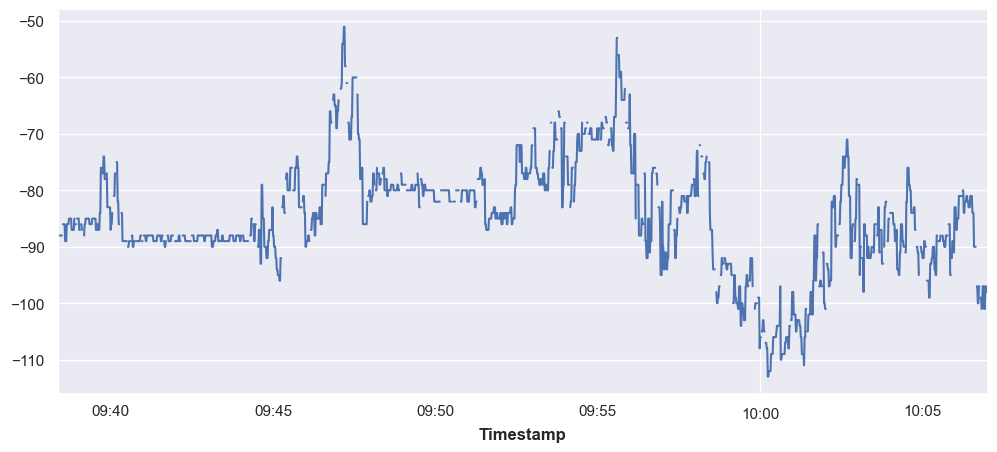

In [ ]:
list_driving_down[2]["RSRP"].plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(list_driving_down[15]["RSRP"].values.flatten())
print(f"Estatística ADF: {result[0]}")
print(f"Valor-p: {result[1]}")

if result[1] < 0.05:
    print("Série é estacionária (provavelmente não tem sazonalidade)")
else:
    print("Série não é estacionária (pode ter sazonalidade)")

MissingDataError: exog contains inf or nans

In [ ]:
import numpy as np
from scipy.fft import fft

In [ ]:
# Detectar periodicidade com FFT

values = list_driving_down[15]["RSRP"].values.flatten()
frequencies = np.abs(fft(values))  # Transformada de Fourier
peak_frequency = (
    np.argmax(frequencies[1:]) + 1
)  # Ignorar a primeira frequência (DC component)
seasonal_period = len(values) // peak_frequency  # Determinar o período sazonal

print(f"Sazonalidade detectada (aproximada): {seasonal_period}")

Sazonalidade detectada (aproximada): 394


In [ ]:
filler = MissingValuesFiller(fill=0.0)  # Preenche valores ausentes
scaler = Scaler()  # Escalona os dados
pipe = Pipeline([filler, scaler])

<Axes: xlabel='Timestamp'>

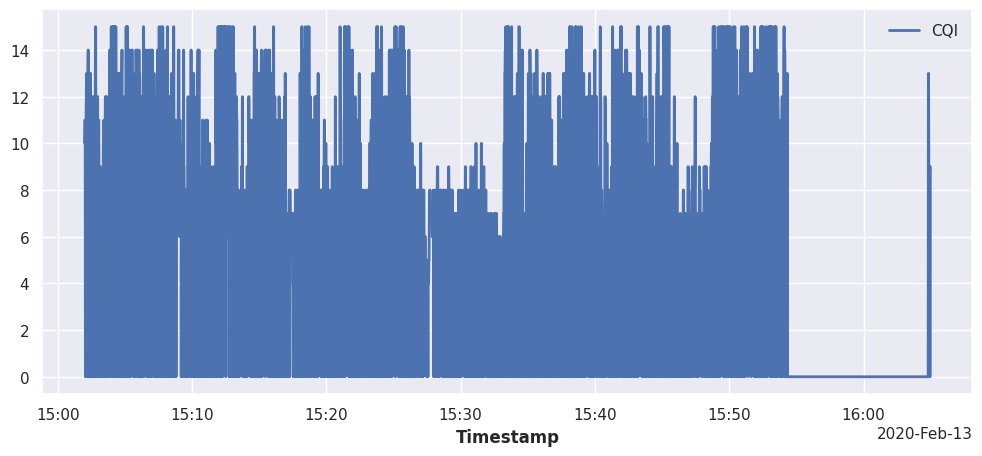

In [ ]:
ts_filled = filler.transform(TimeSeries.from_dataframe(list_driving_down[6])["CQI"])
ts_filled.plot()

<Axes: xlabel='Timestamp'>

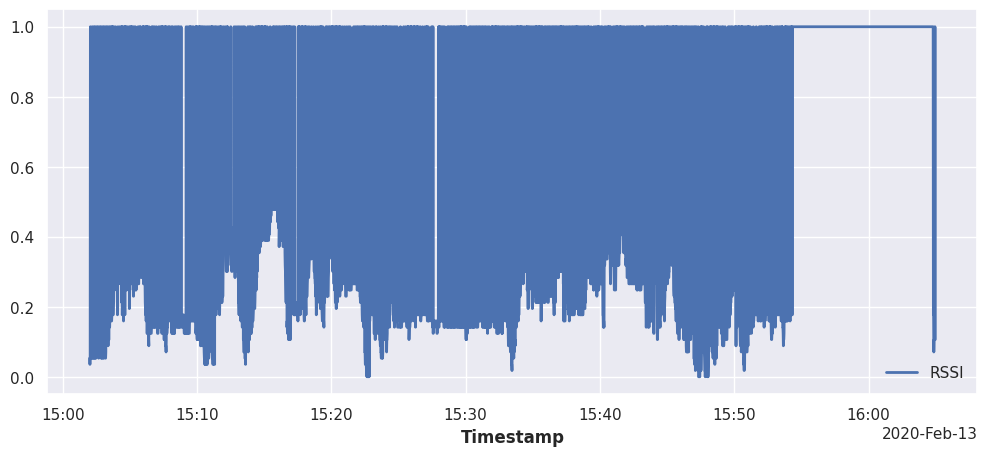

In [ ]:
ts_filled = pipe.fit_transform(TimeSeries.from_dataframe(list_driving_down[6])["RSSI"])
ts_filled.plot()

<Axes: xlabel='Timestamp'>

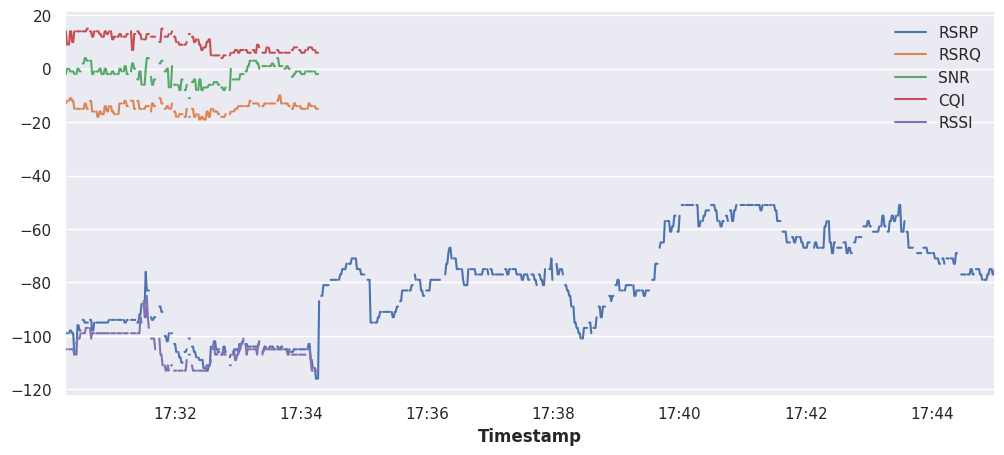

In [ ]:
list_driving_down[10].plot()

<Axes: xlabel='Timestamp'>

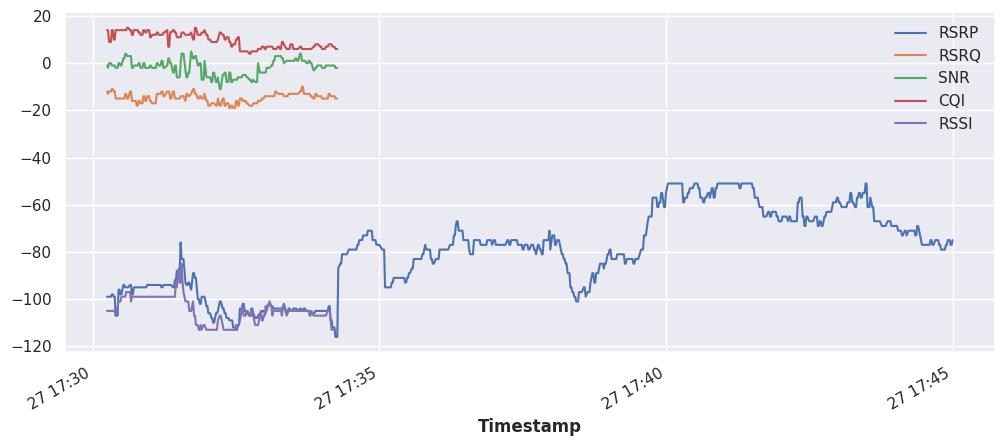

In [ ]:
list_driving_down[10].dropna(how="all").fillna(method="bfill").plot()

In [ ]:
list_driving_down[13].dropna(how="all").fillna(method="bfill")

,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2020-02-14 07:29:00,-90.0,-8.0,5.0,10.0,-105.0
2020-02-14 07:29:01,-90.0,-8.0,5.0,10.0,-107.0
2020-02-14 07:29:03,-88.0,-8.0,-5.0,14.0,-107.0
2020-02-14 07:29:04,-88.0,-13.0,-3.0,11.0,-107.0
2020-02-14 07:29:05,-88.0,-13.0,-3.0,11.0,-107.0
...,...,...,...,...,...
2020-02-14 08:06:45,-63.0,NaN,NaN,NaN,NaN
2020-02-14 08:06:46,-63.0,NaN,NaN,NaN,NaN
2020-02-14 08:06:47,-63.0,NaN,NaN,NaN,NaN


In [ ]:
calculate_nan_percentage(list_driving_strm)

,DataFrame_0,DataFrame_1,DataFrame_2,DataFrame_3,DataFrame_4,DataFrame_5,DataFrame_6,DataFrame_7,DataFrame_8,DataFrame_9,...,DataFrame_34,DataFrame_35,DataFrame_36,DataFrame_37,DataFrame_38,DataFrame_39,DataFrame_40,DataFrame_41,DataFrame_42,DataFrame_43
RSRP,7.339450,6.371191,10.942843,6.808199,7.715582,10.133136,11.229429,11.420266,7.428872,9.978769,...,10.566763,10.416667,11.390771,11.359026,6.633021,10.540360,7.484220,11.664226,10.497238,11.091480
RSRQ,7.339450,6.371191,10.942843,6.808199,7.715582,10.133136,11.229429,11.420266,7.428872,9.978769,...,10.566763,10.416667,11.390771,11.359026,6.633021,10.540360,7.484220,11.664226,10.865562,11.091480
SNR,7.339450,18.928901,23.155838,6.808199,9.795764,10.133136,66.408519,30.793189,17.228662,66.666667,...,10.566763,35.336538,47.402388,11.359026,6.633021,26.484323,11.992786,11.664226,85.267035,22.673734
CQI,7.339450,18.928901,23.155838,6.808199,9.795764,10.133136,66.408519,30.793189,17.228662,66.666667,...,10.566763,35.336538,47.402388,11.359026,6.633021,26.484323,11.992786,11.664226,85.267035,22.673734
RSSI,24.923547,26.315789,30.679043,18.814056,21.293495,18.121302,72.991288,36.171096,20.969442,70.276008,...,23.631124,41.666667,55.211359,14.300203,12.689257,30.353569,18.304779,16.642265,86.372007,29.034158



## Carregando os datasets preparados para treino

In [ ]:
# from darts.datasets import ElectricityDataset

# series = ElectricityDataset().load()

# series[0]

In [ ]:
# Caminho do arquivo Pickle contendo as séries temporais
pickle_file_path = "./data/sliding_window_datasets/driving_down_sliding_window.pkl"

# Carregar as séries temporais do arquivo Pickle
with open(pickle_file_path, "rb") as f:
    time_series_list = pickle.load(f)


In [ ]:
len(time_series_list)

2768

In [ ]:
time_series_list[200]["train"]

<TimeSeries (DataArray) (Timestamp: 50, component: 5, sample: 1)> Size: 2kB
array([[[-100.],
        [ -15.],
        [  -2.],
        [  12.],
        [-101.]],

       [[-104.],
        [ -14.],
        [  -2.],
        [   8.],
        [-101.]],

       [[-101.],
        [ -17.],
        [  -3.],
        [  12.],
        [ -99.]],

       [[  nan],
        [  nan],
...
        [  12.],
        [-103.]],

       [[-100.],
        [ -13.],
        [   2.],
        [  12.],
        [-101.]],

       [[-100.],
        [ -13.],
        [   2.],
        [  12.],
        [-101.]],

       [[  nan],
        [  nan],
        [  nan],
        [  nan],
        [  nan]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 400B 2020-01-16T10:16:56 ... 2020-0...
  * component  (component) object 40B 'RSRP' 'RSRQ' 'SNR' 'CQI' 'RSSI'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Timestamp'>

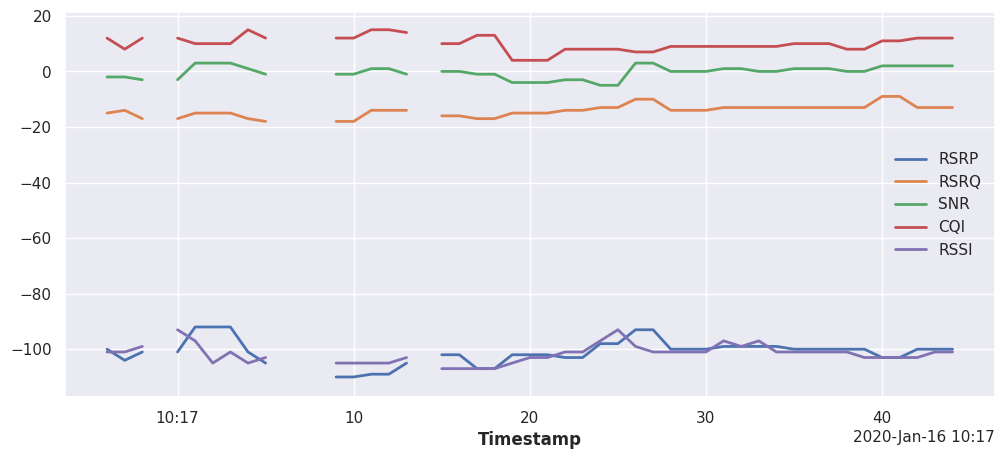

In [ ]:
time_series_list[200]["train"].plot()

In [ ]:
df1 = pd.DataFrame(
    {
        "timestemp": [
            time_series_list[200]["train"]["RSRP"].pd_dataframe().index.to_numpy()
        ],
        "train": [
            time_series_list[200]["train"]["RSRP"].pd_dataframe().values.flatten()
        ],
        "test": [time_series_list[200]["test"]["RSRP"].pd_dataframe().values.flatten()],
        "kpi": "RSRP",
    }
)

df2 = pd.DataFrame(
    {
        "timestemp": [
            time_series_list[200]["train"]["RSRP"].pd_dataframe().index.to_numpy()
        ],
        "train": [
            time_series_list[200]["train"]["RSRP"].pd_dataframe().values.flatten()
        ],
        "test": [time_series_list[200]["test"]["RSRP"].pd_dataframe().values.flatten()],
        "kpi": "RSRP",
    }
)

In [ ]:
pd.concat([df1, df2])

,timestemp,train,test,kpi
0,"[2020-01-16T10:16:56.000000000, 2020-01-16T10:...","[-100.0, -104.0, -101.0, nan, -101.0, -92.0, -...","[-100.0, -96.0, -96.0, -103.0, -103.0, -102.0,...",RSRP
0,"[2020-01-16T10:16:56.000000000, 2020-01-16T10:...","[-100.0, -104.0, -101.0, nan, -101.0, -92.0, -...","[-100.0, -96.0, -96.0, -103.0, -103.0, -102.0,...",RSRP


In [ ]:
time_series_list[200]["train"]["RSRP"].pd_dataframe().values

array([[-100.],
       [-104.],
       [-101.],
       [  nan],
       [-101.],
       [ -92.],
       [ -92.],
       [ -92.],
       [-101.],
       [-105.],
       [  nan],
       [-105.],
       [  nan],
       [-110.],
       [-110.],
       [-109.],
       [-109.],
       [-105.],
       [  nan],
       [-102.],
       [-102.],
       [-107.],
       [-107.],
       [-102.],
       [-102.],
       [-102.],
       [-103.],
       [-103.],
       [ -98.],
       [ -98.],
       [ -93.],
       [ -93.],
       [-100.],
       [-100.],
       [-100.],
       [ -99.],
       [ -99.],
       [ -99.],
       [ -99.],
       [-100.],
       [-100.],
       [-100.],
       [-100.],
       [-100.],
       [-103.],
       [-103.],
       [-100.],
       [-100.],
       [-100.],
       [  nan]])

In [ ]:
time_series_list[200]["test"]["RSRP"].pd_series()

Timestamp
2020-01-16 10:17:46   -100.0
2020-01-16 10:17:47    -96.0
2020-01-16 10:17:48    -96.0
2020-01-16 10:17:49   -103.0
2020-01-16 10:17:50   -103.0
2020-01-16 10:17:51   -102.0
2020-01-16 10:17:52   -102.0
2020-01-16 10:17:53      NaN
2020-01-16 10:17:54   -105.0
2020-01-16 10:17:55   -105.0
Freq: s, Name: RSRP, dtype: float64

## Mais análises

In [ ]:
static_uids = sorted(df_static.Uid.unique().tolist())
display(list(static_uids), f"Quantidade de leituras: {len(static_uids)}")

['42u9UgcX',
 '5TsXJ7Qb',
 '7NmJqtz6',
 '8xwG8Adi',
 'BFgLsizB',
 'ECU7zaAw',
 'GM9ZmFvH',
 'Jhuygmvf',
 'K23smRbN',
 'NsJRz5VB',
 'PQYS4CPo',
 'RGq3ChHg',
 'StMQQFT7',
 'T2versha',
 'Tu48fb57',
 'WNu4V7YR',
 'dGgkDzKH',
 'fJgqmnpu',
 'hk8oyFMg',
 'iNbnVB4U',
 'ksBwo2ee',
 'nD878saz',
 'nwa4P5em']

'Quantidade de leituras: 23'

User_Activity
Streaming Video       18
Name: Uid, dtype: int64

<Axes: xlabel='User_Activity'>

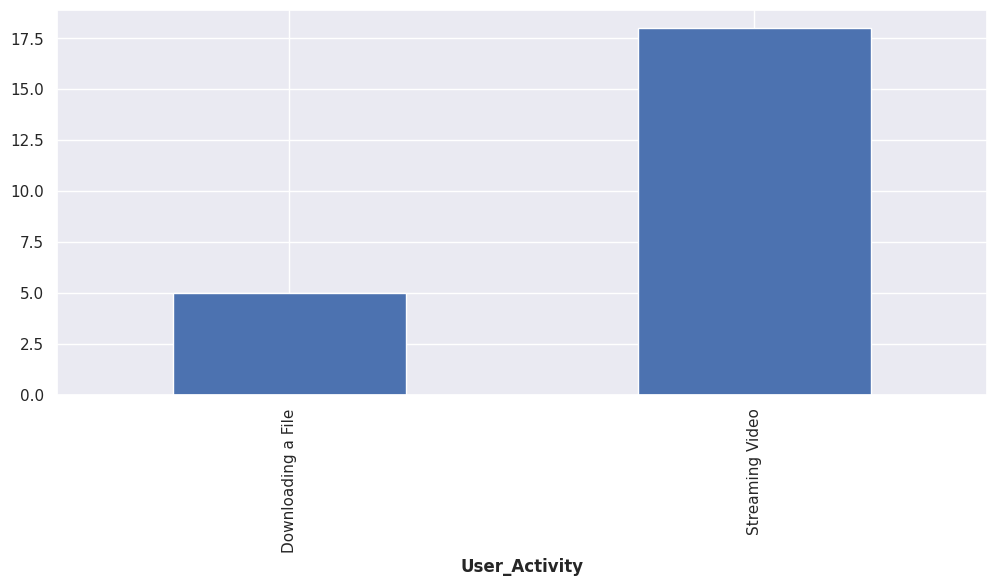

In [ ]:
display(df_static.groupby("User_Activity")["Uid"].nunique())
df_static.groupby("User_Activity")["Uid"].nunique().plot(kind="bar")

In [ ]:
df_static[df_static.Uid == static_uids[0]].head(10)

,Speed,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,Uid,User_Activity
Timestamp,,,,,,,,,,,,
2019-11-26 13:50:48,0,5G,-106.0,-13.0,6.0,11.0,NaN,0,0,I,42u9UgcX,Streaming Video
2019-11-26 13:50:49,0,5G,-107.0,-14.0,4.0,11.0,NaN,0,0,I,42u9UgcX,Streaming Video
2019-11-26 13:50:50,0,5G,-107.0,-14.0,4.0,11.0,NaN,0,0,I,42u9UgcX,Streaming Video
2019-11-26 13:50:51,0,5G,-106.0,-13.0,1.0,11.0,NaN,2,4,D,42u9UgcX,Streaming Video
2019-11-26 13:50:52,0,5G,-106.0,-13.0,1.0,13.0,-88.0,433,245,D,42u9UgcX,Streaming Video
2019-11-26 13:50:53,0,5G,-103.0,-14.0,4.0,12.0,-86.0,11366,497,D,42u9UgcX,Streaming Video
2019-11-26 13:50:54,0,5G,-103.0,-14.0,4.0,12.0,-86.0,18419,672,D,42u9UgcX,Streaming Video
2019-11-26 13:50:55,1,5G,-103.0,-14.0,4.0,12.0,-86.0,18419,672,D,42u9UgcX,Streaming Video
2019-11-26 13:50:57,1,5G,-103.0,-17.0,2.0,12.0,-86.0,5464,206,D,42u9UgcX,Streaming Video


In [ ]:
test_static_df = (
    df_static[df_static.Uid == static_uids[0]][
        ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
    ].asfreq(freq="S")
    # .bfill()
)
test_static_df.head(10)

,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2019-11-26 13:50:48,-106.0,-13.0,6.0,11.0,NaN
2019-11-26 13:50:49,-107.0,-14.0,4.0,11.0,NaN
2019-11-26 13:50:50,-107.0,-14.0,4.0,11.0,NaN
2019-11-26 13:50:51,-106.0,-13.0,1.0,11.0,NaN
2019-11-26 13:50:52,-106.0,-13.0,1.0,13.0,-88.0
2019-11-26 13:50:53,-103.0,-14.0,4.0,12.0,-86.0
2019-11-26 13:50:54,-103.0,-14.0,4.0,12.0,-86.0
2019-11-26 13:50:55,-103.0,-14.0,4.0,12.0,-86.0
2019-11-26 13:50:56,NaN,NaN,NaN,NaN,NaN


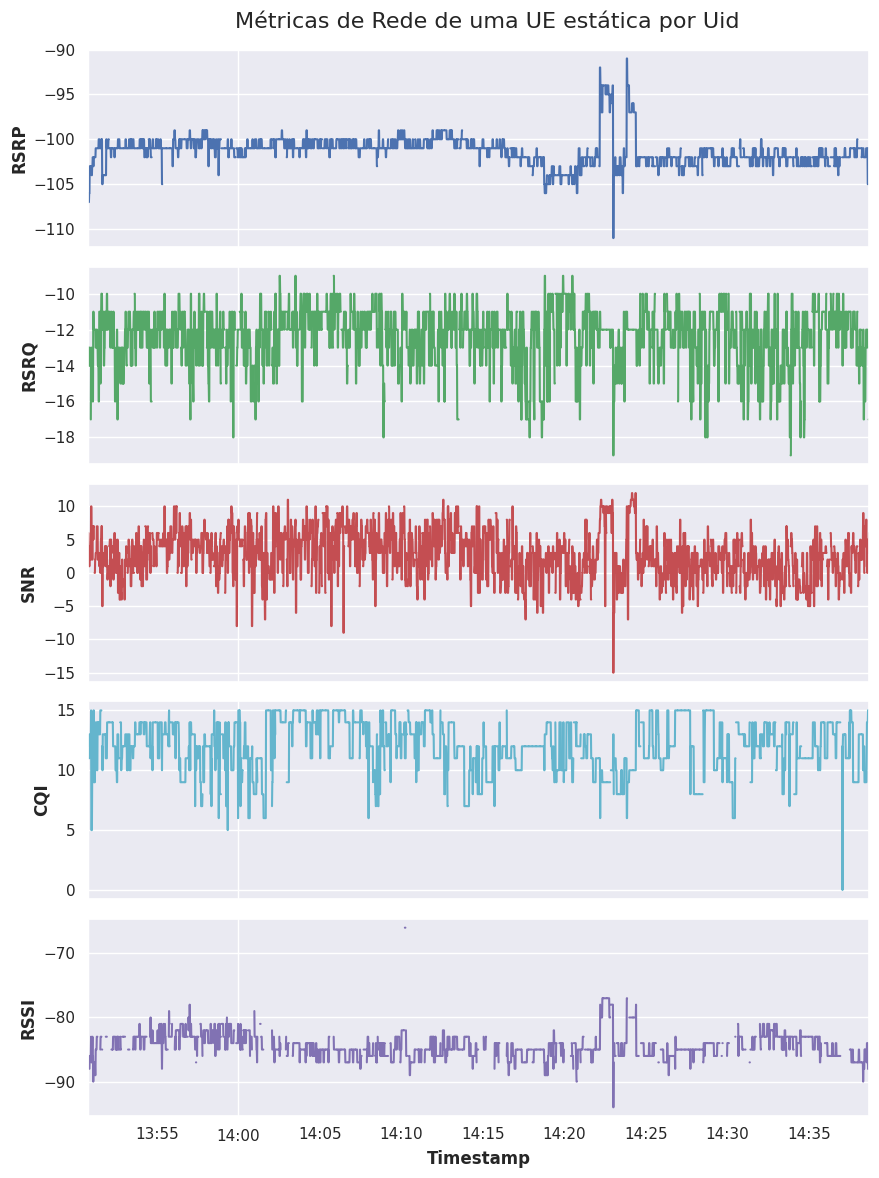

In [ ]:
# Criar a figura e os eixos
fig, ax = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Plotar as variáveis nos subplots
test_static_df.plot(kind="line", y="RSRP", color="b", ax=ax[0], legend=False)
test_static_df.plot(kind="line", y="RSRQ", color="g", ax=ax[1], legend=False)
test_static_df.plot(kind="line", y="SNR", color="r", ax=ax[2], legend=False)
test_static_df.plot(kind="line", y="CQI", color="c", ax=ax[3], legend=False)
test_static_df.plot(kind="line", y="RSSI", color="m", ax=ax[4], legend=False)

# Definir os títulos de cada eixo y
ax[0].set_ylabel("RSRP")
ax[1].set_ylabel("RSRQ")
ax[2].set_ylabel("SNR")
ax[3].set_ylabel("CQI")
ax[4].set_ylabel("RSSI")

fig.suptitle("Métricas de Rede de uma UE estática por Uid", fontsize=16)

# # Configurar a legenda em uma posição consistente
# lines = [ax[0].lines[0], ax[1].lines[0], ax[2].lines[0], ax[3].lines[0], ax[4].lines[0]]
# labels = ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
# fig.legend(lines, labels, loc="upper right", bbox_to_anchor=(1.1, 1), title="Métricas")

# Ajustar o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 0.9, 1])

In [ ]:
ts_static = TimeSeries.from_dataframe(
    test_static_df,
    value_cols=["RSRP", "RSRQ", "SNR", "CQI", "RSSI"],
    # fill_missing_dates=True,  # Adiciona NaN para os segundos ausentes
    # freq="s",
)

In [ ]:
ts_static.time_index.values

array(['2019-11-26T13:50:48.000000000', '2019-11-26T13:50:49.000000000',
       '2019-11-26T13:50:50.000000000', ...,
       '2019-11-26T14:38:40.000000000', '2019-11-26T14:38:41.000000000',
       '2019-11-26T14:38:42.000000000'], dtype='datetime64[ns]')

In [ ]:
ts_static["RSRP"].all_values().flatten()

array([-106., -107., -107., ..., -101., -101., -101.])

## Driving

In [ ]:
df_driving = pd.read_parquet(os.path.join(os.curdir, "data", "5G_df_driving.parquet"))

In [ ]:
driving_uids = sorted(df_driving.Uid.unique().tolist())
display(list(driving_uids), f"Quantidade de leituras: {len(driving_uids)}")

['297FZypZ',
 '4F2EyAD3',
 '4dRydYjp',
 '6WrsU6ix',
 '9DWopAGC',
 'AGgmh8yf',
 'AsFpmia9',
 'BMGPBjya',
 'C55SDPhc',
 'D7S47wsb',
 'DGUzdHuE',
 'DwGchQdb',
 'EFh7zDgY',
 'EjHAbVMV',
 'HThSzqKR',
 'HaCeE7bY',
 'J24QkZ2u',
 'J4V6Y25d',
 'JsVEJPwy',
 'K6TUUt3r',
 'LFvR86yz',
 'LUnJJANP',
 'Lm4nnZ3y',
 'N5MLYKPm',
 'NKpgdgV2',
 'NQBoGSiU',
 'QLGJh8iL',
 'R6WuRYsG',
 'RngjUM9j',
 'S8T9Psem',
 'TdPps7ts',
 'USfaqZw5',
 'Urb4trhB',
 'UsyKjy6F',
 'V8v7LRaC',
 'Vt8bosWC',
 'Vx2d8RdC',
 'WhUU4LAT',
 'XeL3nqTb',
 'Y5FhsGKa',
 'Z62L5upe',
 'ZQKVQjuh',
 'aaKkzbhj',
 'dyU6zEzJ',
 'eGbYrDta',
 'eqWpbbNX',
 'f3sTfFKF',
 'g3QU7W4C',
 'hzLTojbW',
 'iD2CYP32',
 'iVRz9MhC',
 'iYDrhdHp',
 'iqSNwzTV',
 'jpwbCC3y',
 'kmTLbSon',
 'mFsVp3xN',
 'mRnvfwGW',
 'mqxcBQJT',
 'nLFJYs33',
 'nhatZCUd']

'Quantidade de leituras: 60'

User_Activity
Streaming Video       44
Name: Uid, dtype: int64

<Axes: xlabel='User_Activity'>

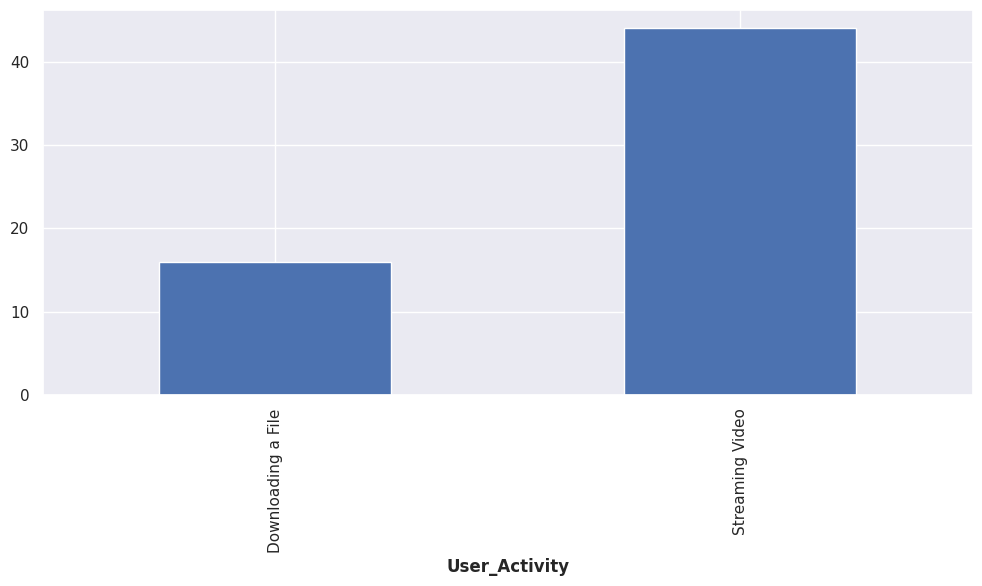

In [ ]:
display(df_driving.groupby("User_Activity")["Uid"].nunique())
df_driving.groupby("User_Activity")["Uid"].nunique().plot(kind="bar")

In [ ]:
df_driving.query("User_Activity == 'Downloading a File'")

,Speed,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,Uid,User_Activity
Timestamp,,,,,,,,,,,,
2019-12-14 10:16:30,0,5G,-99.0,-15.0,6.0,12.0,-90.0,7,1,D,USfaqZw5,Downloading a File
2019-12-14 10:16:31,1,5G,-99.0,-15.0,6.0,12.0,-90.0,7,1,D,USfaqZw5,Downloading a File
2019-12-14 10:16:32,1,5G,-102.0,-14.0,6.0,12.0,-90.0,0,0,D,USfaqZw5,Downloading a File
2019-12-14 10:16:33,1,5G,-102.0,-14.0,6.0,12.0,-90.0,9,12,D,USfaqZw5,Downloading a File
2019-12-14 10:16:34,1,5G,-102.0,-14.0,4.0,12.0,-90.0,0,0,D,USfaqZw5,Downloading a File
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27 20:50:01,24,HSPA+,-71.0,NaN,NaN,NaN,NaN,4616,74,D,J24QkZ2u,Downloading a File
2020-02-27 20:50:02,24,HSPA+,-71.0,NaN,NaN,NaN,NaN,5089,88,D,J24QkZ2u,Downloading a File
2020-02-27 20:50:03,24,HSPA+,-69.0,NaN,NaN,NaN,NaN,5383,105,D,J24QkZ2u,Downloading a File


In [ ]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[0]][
        ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
    ].asfreq(freq="S")
    # .bfill()
)
test_driving_df.head(10)

,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2019-12-02 12:41:17,-105.0,-13.0,-1.0,9.0,-87.0
2019-12-02 12:41:18,-105.0,-13.0,-1.0,9.0,-87.0
2019-12-02 12:41:19,-104.0,-12.0,1.0,9.0,-87.0
2019-12-02 12:41:20,-103.0,-13.0,-4.0,9.0,-87.0
2019-12-02 12:41:21,-103.0,-13.0,-4.0,9.0,-87.0
2019-12-02 12:41:22,-106.0,-9.0,-1.0,13.0,-89.0
2019-12-02 12:41:23,-106.0,-9.0,-1.0,13.0,-89.0
2019-12-02 12:41:24,-105.0,-9.0,-2.0,9.0,-86.0
2019-12-02 12:41:25,-105.0,-9.0,-2.0,9.0,-86.0


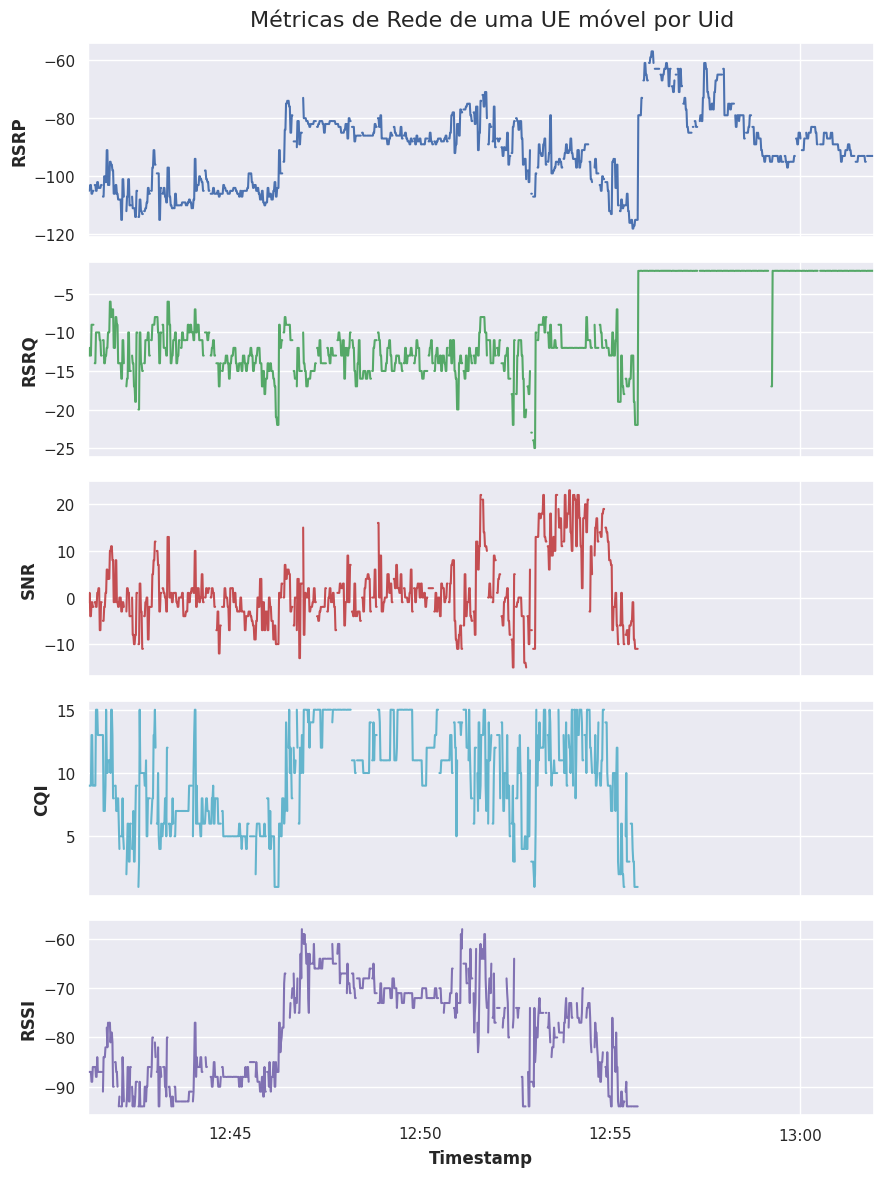

In [ ]:
# Criar a figura e os eixos
fig, ax = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Plotar as variáveis nos subplots
test_driving_df.plot(kind="line", y="RSRP", color="b", ax=ax[0], legend=False)
test_driving_df.plot(kind="line", y="RSRQ", color="g", ax=ax[1], legend=False)
test_driving_df.plot(kind="line", y="SNR", color="r", ax=ax[2], legend=False)
test_driving_df.plot(kind="line", y="CQI", color="c", ax=ax[3], legend=False)
test_driving_df.plot(kind="line", y="RSSI", color="m", ax=ax[4], legend=False)

# Definir os títulos de cada eixo y
ax[0].set_ylabel("RSRP")
ax[1].set_ylabel("RSRQ")
ax[2].set_ylabel("SNR")
ax[3].set_ylabel("CQI")
ax[4].set_ylabel("RSSI")

fig.suptitle("Métricas de Rede de uma UE móvel por Uid", fontsize=16)

# # Configurar a legenda em uma posição consistente
# lines = [ax[0].lines[0], ax[1].lines[0], ax[2].lines[0], ax[3].lines[0], ax[4].lines[0]]
# labels = ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
# fig.legend(lines, labels, loc="upper right", bbox_to_anchor=(1.1, 1), title="Métricas")

# Ajustar o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 0.9, 1])

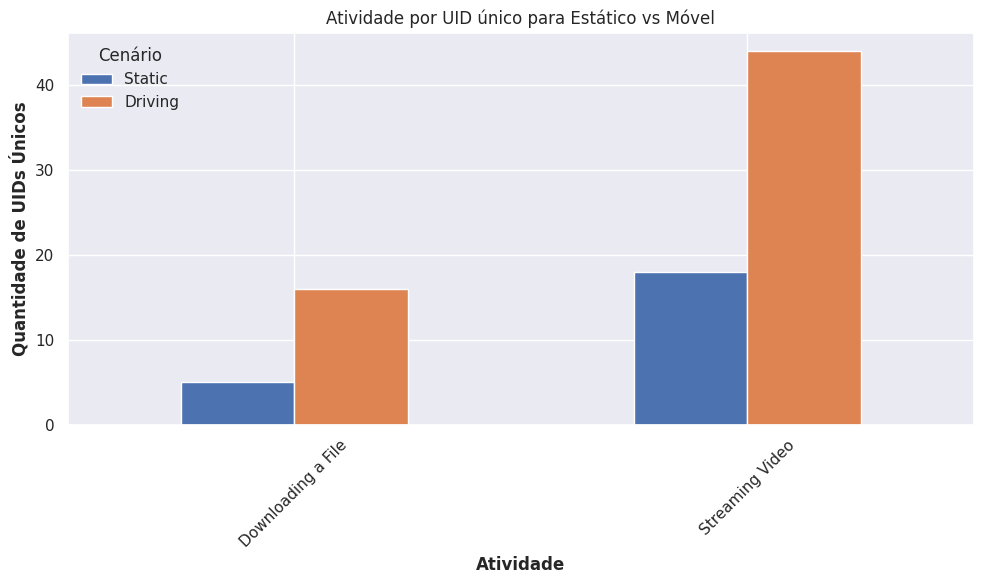

In [ ]:
static_uid_counts = df_static.groupby("User_Activity")["Uid"].nunique().rename("Static")
driving_uid_counts = (
    df_driving.groupby("User_Activity")["Uid"].nunique().rename("Driving")
)

# Combinar os resultados em um único DataFrame
combined_uid_counts = pd.concat([static_uid_counts, driving_uid_counts], axis=1)

# Plotar o gráfico de barras
combined_uid_counts.plot(kind="bar", figsize=(10, 6))
plt.title("Atividade por UID único para Estático vs Móvel")
plt.xlabel("Atividade")
plt.ylabel("Quantidade de UIDs Únicos")
plt.xticks(rotation=45)
plt.legend(title="Cenário")
plt.tight_layout()
plt.show()

## Verificação de Estacionaridade

### 1. Verificar a estacionaridade usando o Teste de Dickey-Fuller Aumentado

Uma série temporal é considerada "estacionária" se **não apresenta tendência**, exibe **variância constante** ao longo do tempo e possui uma estrutura de **autocorrelação constante** ao longo do tempo.

Uma maneira de testar se uma série temporal é estacionária é realizar um teste de **Dickey-Fuller aumentado**, que utiliza as seguintes hipóteses nulas e alternativas:

> $H_0$: A série temporal **não é estacionária**. Em outras palavras, ela possui alguma estrutura dependente do tempo e não apresenta variância constante ao longo do tempo.

> $H_A$: A série temporal **é estacionária**.

Se o **valor de p** do teste for **menor que** algum nível de **significância** (por exemplo, **α = 0,05**), então podemos **rejeitar a hipótese nula** e concluir que a série temporal **é estacionária**.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][
        ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
    ]
    .asfreq(freq="S")
    .bfill()
)

<Axes: xlabel='Timestamp'>

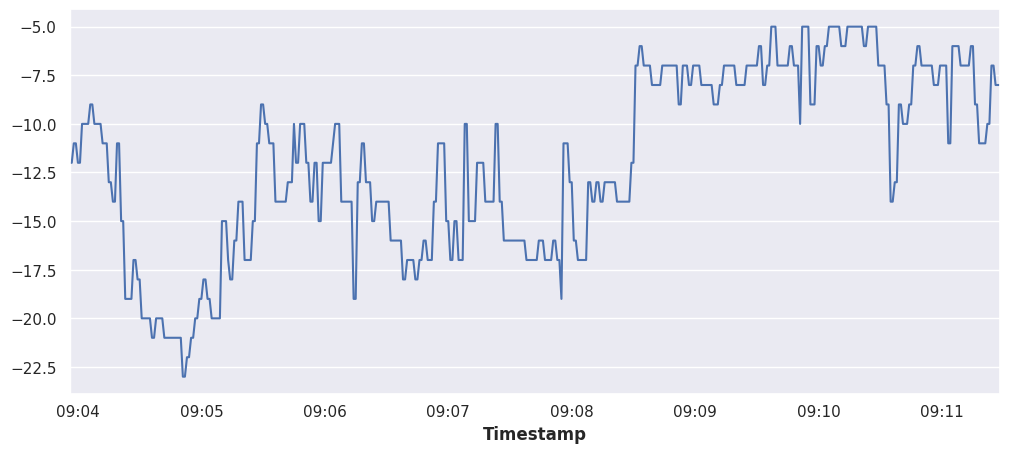

In [ ]:
test_driving_df["RSRQ"].plot()

In [ ]:
# Teste de Dickey-Fuller Aumentado
result = adfuller(test_driving_df["RSRQ"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária")

ADF Statistic: -2.0218496188657613
p-value: 0.27707573129452506
A série não é estacionária


Interpretação dos Resultados:

- **Estatística ADF (ADF Statistic):** Valor da estatística de teste. Valores mais negativos indicam uma série mais fortemente estacionária.
- **p-value:** Probabilidade associada ao teste. Um p-valor abaixo de 0.05 geralmente indica que a série é estacionária, pois rejeita a hipótese nula de que a série possui uma unidade raiz (não estacionária).
- **Valores Críticos (Critical Values):** Ponto de corte para diferentes níveis de significância (1%, 5%, e 10%).

## 2. Aplicação de Diferenciação para Remover Tendência. 

Se o p-valor do teste ADF for maior que 0.05, a série não é estacionária, e precisamos aplicar diferenciação.

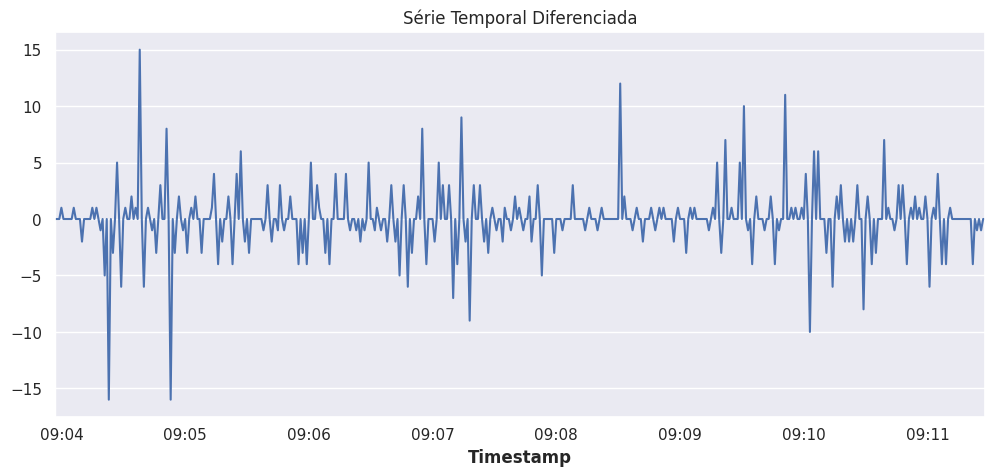

In [ ]:
# Aplicando a primeira diferença
series_diff = test_driving_df["RSRP"].diff().dropna()

# Visualizar a série diferenciada
series_diff.plot(title="Série Temporal Diferenciada")
plt.show()

In [ ]:
# Teste de Dickey-Fuller na série diferenciada
result_diff = adfuller(series_diff)
print("ADF Statistic (differenced):", result_diff[0])
print("p-value (differenced):", result_diff[1])

ADF Statistic (differenced): -12.987150093987132
p-value (differenced): 2.8624820901802593e-24


A diferenciação pode ser aplicada repetidamente a uma série temporal até que ela se torne estacionária. No contexto de modelagem ARIMA, o número de vezes que a diferenciação é aplicada está relacionado com o parâmetro d do modelo ARIMA (p, d, q).

- **Evite Overdifferencing:** Diferenciar a série mais do que o necessário pode levar a problemas na modelagem e na interpretação dos resultados. Idealmente, o número de diferenciações deve ser o menor possível para alcançar a estacionaridade.
- **Análise Visual:** Além dos testes estatísticos, análises visuais dos gráficos de séries temporais diferenciadas, ACF, e PACF também são úteis para decidir o nível adequado de diferenciação.

### 3. Autocorrelação (ACF) e a autocorrelação parcial (PACF) para identificar componentes sazonais

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


- Autocorrelação (ACF): 
  - O gráfico de autocorrelação mostra a correlação da série com suas próprias versões defasadas (lags). Quando uma série temporal possui componentes sazonais, o gráfico de ACF geralmente mostra picos em lags múltiplos do período sazonal. Por exemplo, se há um padrão sazonal anual em dados mensais, picos significativos na ACF aparecerão nos lags 12, 24, 36, etc.
- Autocorrelação parcial (PACF): 
  - O gráfico de autocorrelação parcial mostra a correlação entre a série e suas defasagens, excluindo o efeito das defasagens intermediárias. Na presença de sazonalidade, a PACF pode mostrar picos significativos nos lags correspondentes ao período sazonal. A PACF é útil para entender a estrutura subjacente de um modelo autorregressivo e para diferenciar entre componentes sazonais e de tendência.

In [ ]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][
        ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
    ]
    .asfreq(freq="S")
    .bfill()
)

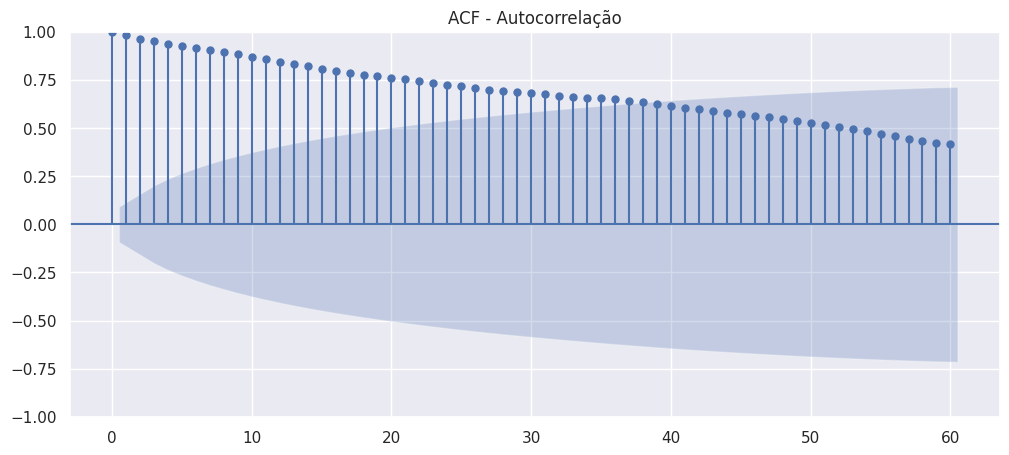

In [ ]:
# Plotar ACF
plot_acf(test_driving_df["RSRP"], lags=60)
plt.title("ACF - Autocorrelação")
plt.show()

Interpretação do ACF:
- Apresentar um comportamento decrescente sem picos significativos em lags específicos, isso geralmente indica que a série temporal não possui uma sazonalidade forte ou distinta.

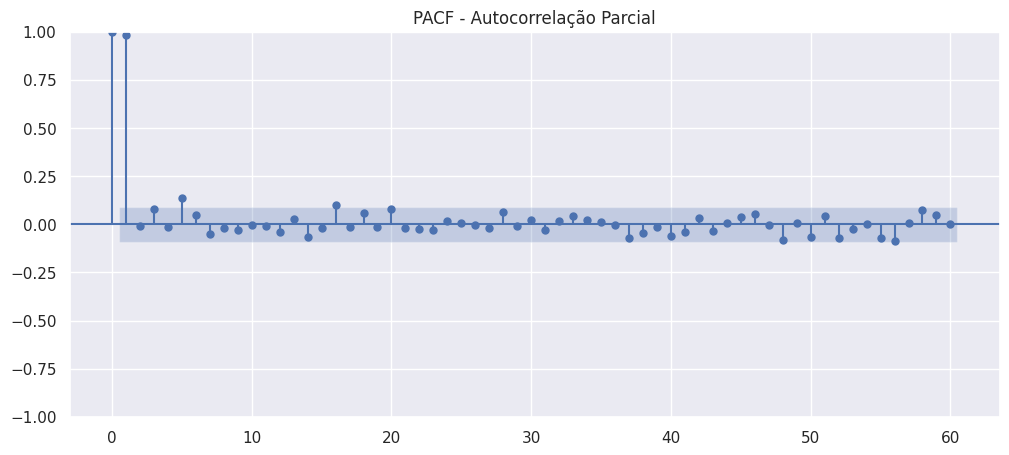

In [ ]:
# Plotar PACF
plot_pacf(test_driving_df["RSRP"], lags=60)
plt.title("PACF - Autocorrelação Parcial")
plt.show()

Interpretação do PACF:
- Valor Alto em Lag 0:
    -Lag 0 representa a autocorrelação da série com ela mesma, que é sempre 1, pois cada ponto está perfeitamente correlacionado consigo mesmo.
- Valores Altos nos Lags 1 e 2:
    -Valores altos em lag 1 e especialmente em lag 2 sugerem que a série tem uma dependência significativa dos valores observados dois períodos antes. Isso é típico de um processo autoregressivo de ordem 2 (AR(2)).

Interpretação dos Gráficos
- ACF: Um ACF que decresce exponencialmente pode sugerir que a série é bem representada por um modelo autoregressivo (AR), onde os valores são influenciados pelos valores anteriores, mas essa influência decai com o tempo. Neste caso, a PACF pode mostrar um corte abrupto após o primeiro ou segundo lag, o que ajuda a identificar a ordem do modelo AR.
- PACF com Corte Abaixo de um Certo Lag: Um corte claro na PACF após o primeiro ou segundo lag sugere um modelo AR de baixa ordem.

## The Hodrick-Prescott Filter:

Separetes a time-series $y_t$ into a trend component $\tau_t$ and a cyclical component $c_t$.

$$ y_t = \tau_t + c_t $$

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [ ]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][
        ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
    ]
    .asfreq(freq="S")
    .bfill()
)

In [ ]:
RSRP_cycle, RSRP_trend = hpfilter(test_driving_df["RSRP"], lamb=1600)

<Axes: xlabel='Timestamp'>

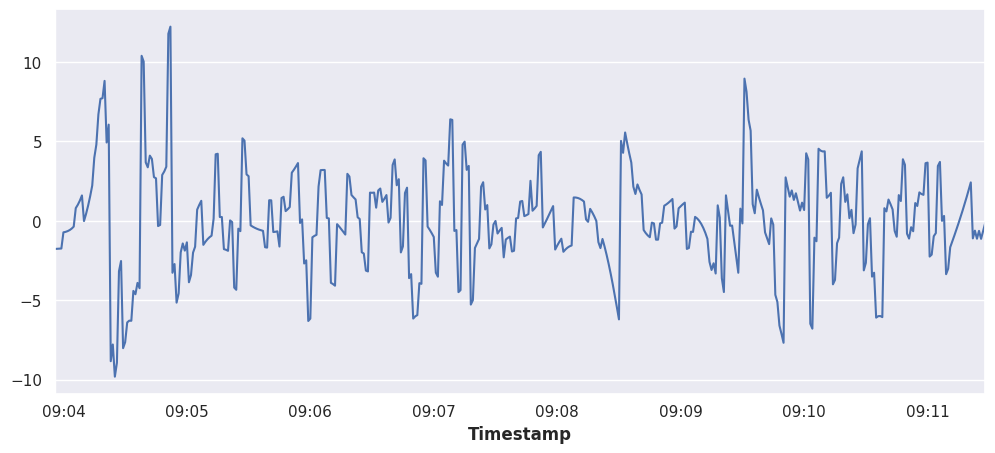

In [ ]:
RSRP_cycle.plot()

<Axes: xlabel='Timestamp'>

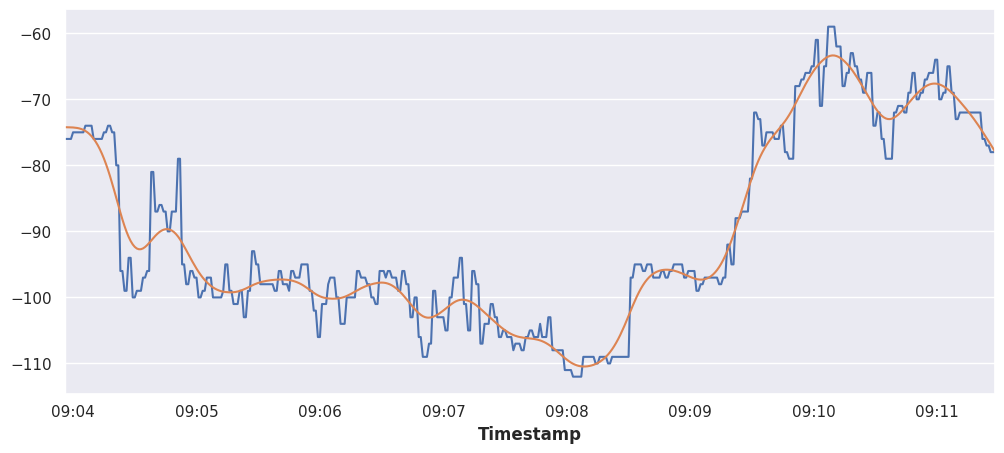

In [ ]:
test_driving_df["RSRP"].plot()
RSRP_trend.plot()

## The ETS (Error-Trend-Seasonality) Models:

ETS (Exponential Smoothing) is a time series forecasting technique that combines three main components: error (E), trend (T), and seasonality (S). It smooths past data to predict future values by applying exponentially decreasing weights over time. There are various types of ETS models, including additive and multiplicative models, depending on how trend and seasonality interact with the time series data. ETS is particularly useful for data exhibiting seasonal patterns and trends, enabling accurate forecasts in scenarios where these components are significant.

- An additive model is applied when the trend appears linear and both the seasonality and trend components seem constant over time.
- A multiplicative model is more appropriate when the trend is increasing (or decreasing) at a non-linear rate.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][
        ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
    ]
    .asfreq(freq="S")
    .bfill()
)

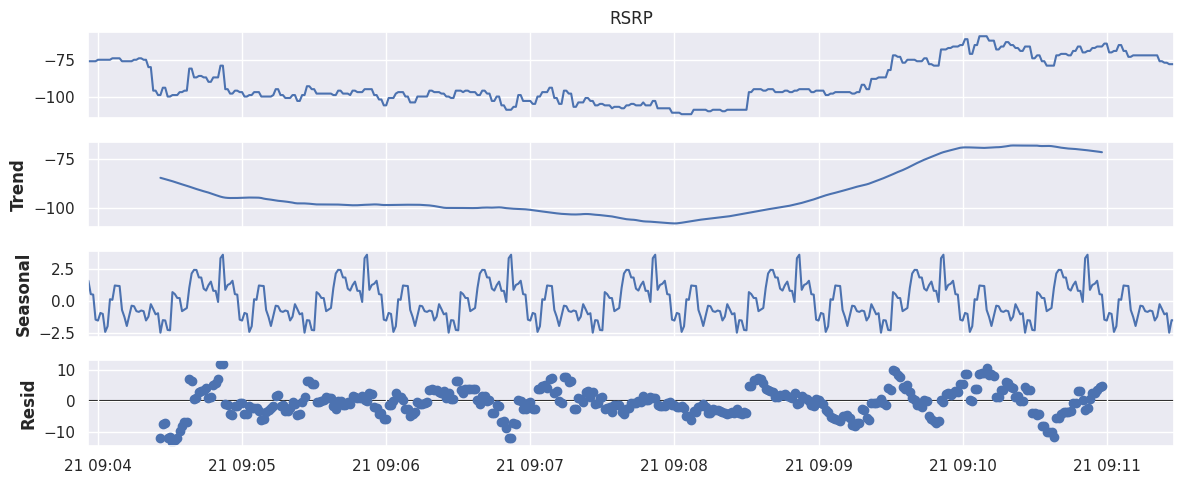

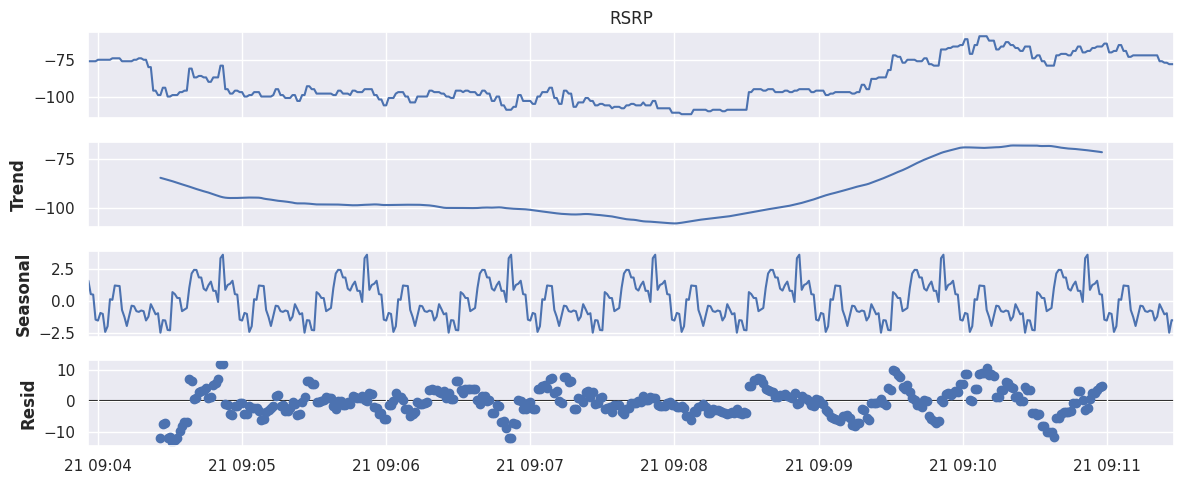

In [ ]:
seasonal_decompose(test_driving_df["RSRP"], model="add", period=60).plot()

## Rolling Moving Average

In [ ]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][
        ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
    ]
    .asfreq(freq="S")
    .bfill()
)

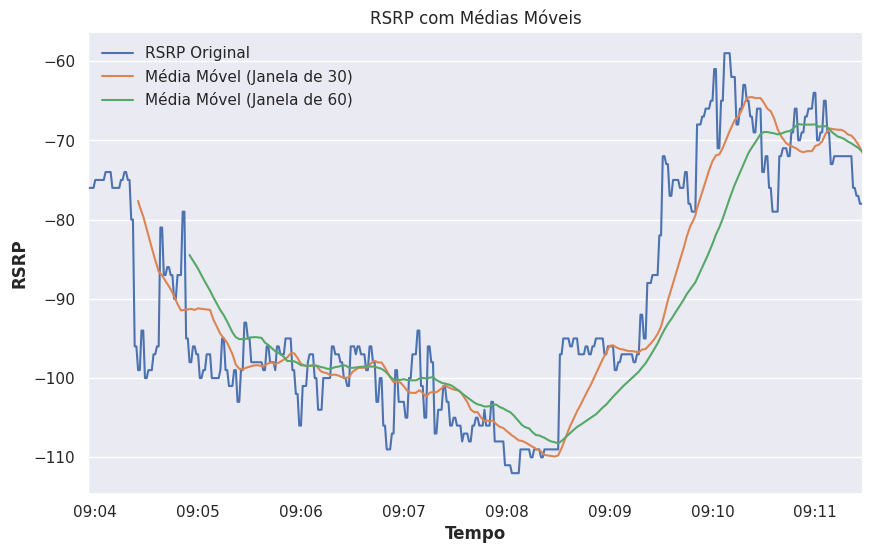

In [ ]:
# Plot da série original de RSRP
test_driving_df["RSRP"].plot(label="RSRP Original", figsize=(10, 6))

# Plot da média móvel com janela de 30
test_driving_df["RSRP"].rolling(window=30).mean().plot(
    label="Média Móvel (Janela de 30)"
)

# Plot da média móvel com janela de 60
test_driving_df["RSRP"].rolling(window=60).mean().plot(
    label="Média Móvel (Janela de 60)"
)

# Adicionar título e legenda
plt.title("RSRP com Médias Móveis")
plt.xlabel("Tempo")
plt.ylabel("RSRP")
plt.legend()

## EWMA (Exponentially weighted moving average)

In [ ]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][
        ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
    ]
    .asfreq(freq="S")
    .bfill()
)

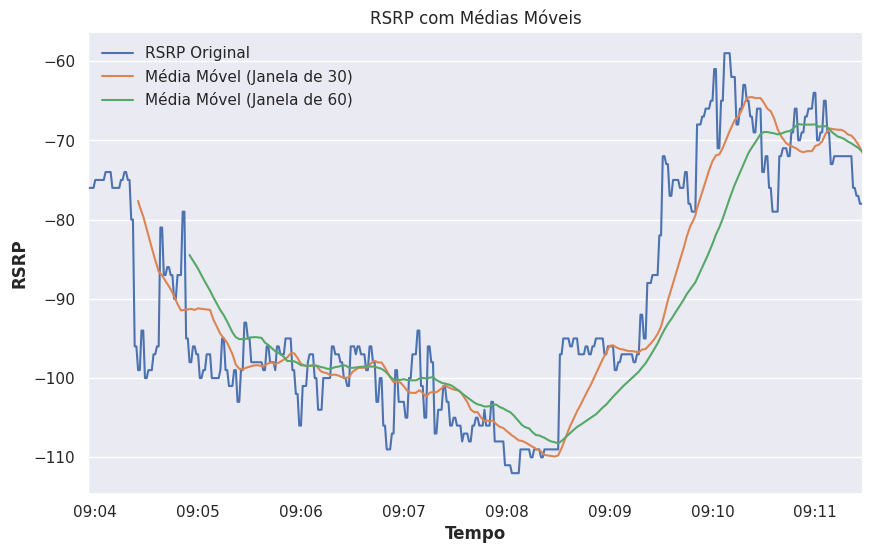

In [ ]:
# Plot da série original de RSRP
test_driving_df["RSRP"].plot(label="RSRP Original", figsize=(10, 6))

# Plot da média móvel com janela de 30
test_driving_df["RSRP"].rolling(window=30).mean().plot(
    label="Média Móvel (Janela de 30)"
)

# Plot da média móvel com janela de 60
test_driving_df["RSRP"].rolling(window=60).mean().plot(
    label="Média Móvel (Janela de 60)"
)

# Adicionar título e legenda
plt.title("RSRP com Médias Móveis")
plt.xlabel("Tempo")
plt.ylabel("RSRP")
plt.legend()

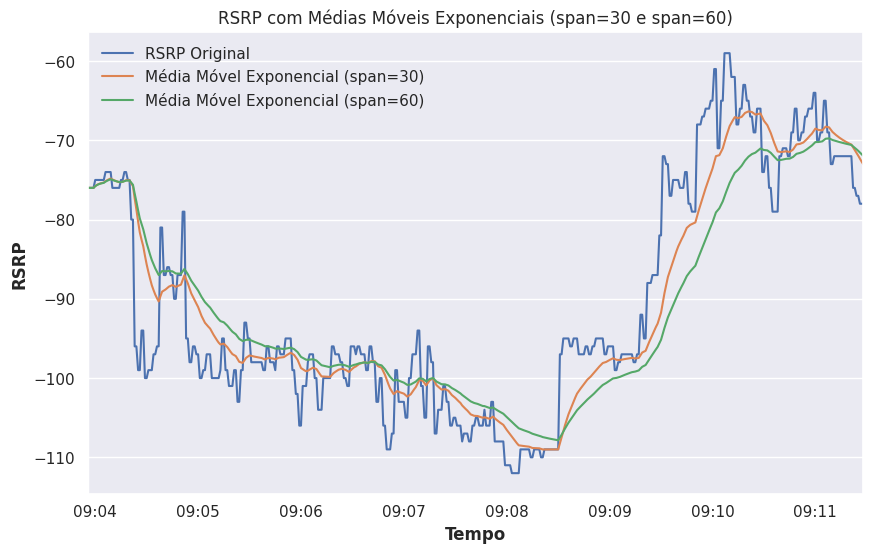

In [ ]:
# Plot da série original de RSRP
test_driving_df["RSRP"].plot(label="RSRP Original", figsize=(10, 6))

# Plot da média móvel exponencial com span de 30
test_driving_df["RSRP"].ewm(span=30).mean().plot(
    label="Média Móvel Exponencial (span=30)"
)

# Plot da média móvel exponencial com span de 60
test_driving_df["RSRP"].ewm(span=60).mean().plot(
    label="Média Móvel Exponencial (span=60)"
)

# Adicionar título, legendas e exibir o gráfico
plt.title("RSRP com Médias Móveis Exponenciais (span=30 e span=60)")
plt.xlabel("Tempo")
plt.ylabel("RSRP")
plt.legend()

Estudar:

  - https://www.youtube.com/watch?v=CAT0Y66nPhs
  - https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb

Código para referência:

- https://github.com/KareemElozeiri/CQI-Timeseries-Forecasting/blob/main/notebooks/CQI_Time_Series_Forecasting.ipynb